In [1]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [2]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [3]:
def load_img(img_path, shape = None):
    max_size = 500
    image = Image.open(img_path).convert('RGB')

    size = max_size if max(image.size) > max_size else max(image.size)

    if shape is not None:
        size = shape
    transform = transforms.Compose([
                                    transforms.Resize(size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.452, 0.391, 0.582),
                                                         (0.228, 0.253, 0.191))
    ])

    image = transform(image)[:3, :, :].unsqueeze(0)

    return image

In [4]:
content = load_img('images/camel.jpg').to(device)
style = load_img('images/camel_painting.jpeg', shape = content.shape[-2:]).to(device)

In [5]:
#for unnormalizing the image
def img_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.228, 0.253, 0.191)) + np.array((0.452, 0.391, 0.582))

    image = image.clip(0,1)

    return image

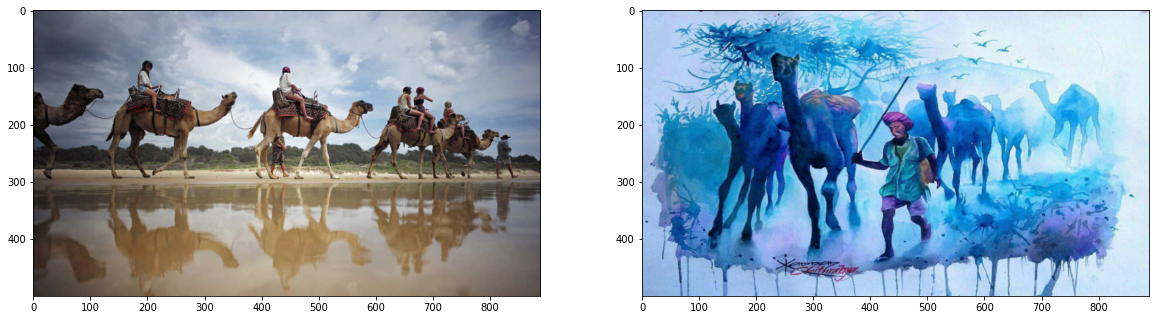

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))

ax1.imshow(img_convert(content))
ax2.imshow(img_convert(style))

In [7]:
def get_features(image, model, layers = None):
    if layers is None:
        layers = {'0' : 'conv1_1',
                  '5' : 'conv2_1',
                  '10' : 'conv3_1',
                  '19' : 'conv4_1',
                  '21' : 'conv4_2',
                  '28' : 'conv5_1'}
    features = {}
    x = image

    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features    

In [8]:
#calculate the gram matrix
def get_gram_matrix(tensor):
    _,d,w,h = tensor.size()

    tensor = tensor.view(d, w*h)
    gram_matrix = torch.mm(tensor, tensor.t())

    return gram_matrix

In [9]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: get_gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

In [12]:
style_weights = {'conv1_1': 1,
                 'conv2_1': 0.85,
                 'conv3_1': 0.55,
                 'conv4_1': 0.25,
                 'conv5_1': 0.2}

content_weight = 1
style_weight = 1e6

Total loss:  11882178.0


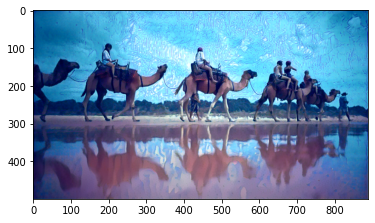

Total loss:  5522480.0


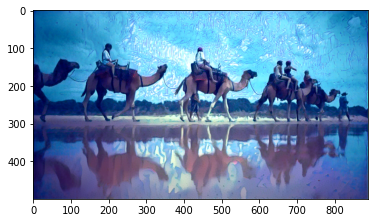

Total loss:  3525476.0


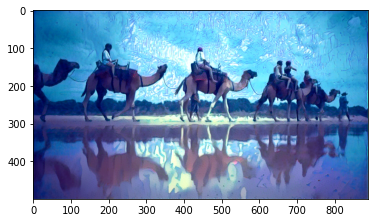

Total loss:  2438018.25


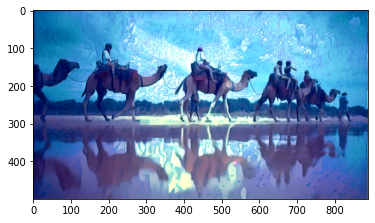

Total loss:  1773258.5


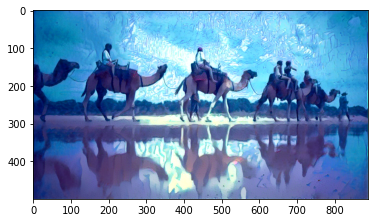

Total loss:  1313880.75


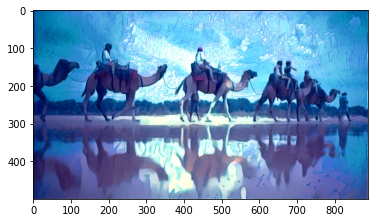

Total loss:  983218.4375


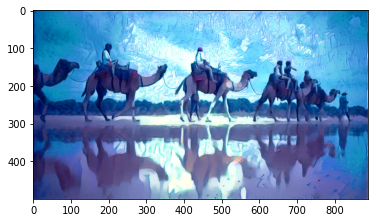

Total loss:  743228.5625


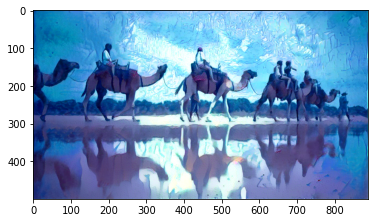

Total loss:  567504.625


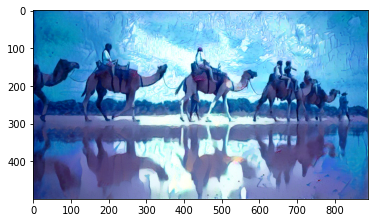

Total loss:  440805.65625


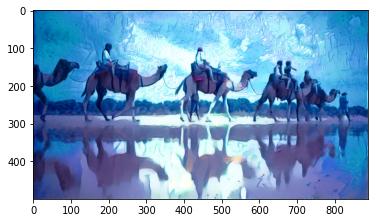

Total loss:  349597.90625


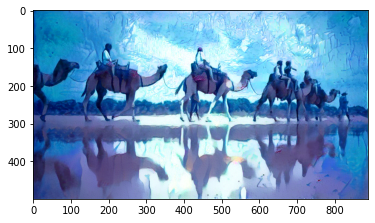

Total loss:  282158.1875


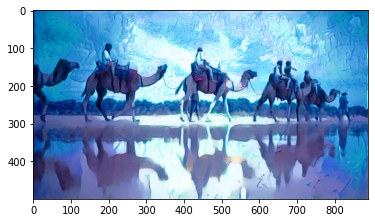

In [13]:
show_img_in = 400

optimizer = optim.Adam([target], lr= 0.003)
epoches = 5000

for epoch in range(1, epoches + 1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0.0

    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = get_gram_matrix(target_feature)

        _,d,w,h = target_feature.shape

        style_gram = style_grams[layer]
        style_loss_in_layer = style_weights[layer]*torch.mean((target_gram - style_gram)**2)
        style_loss += style_loss_in_layer/(d*h*w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % show_img_in == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(img_convert(target))
        plt.show()

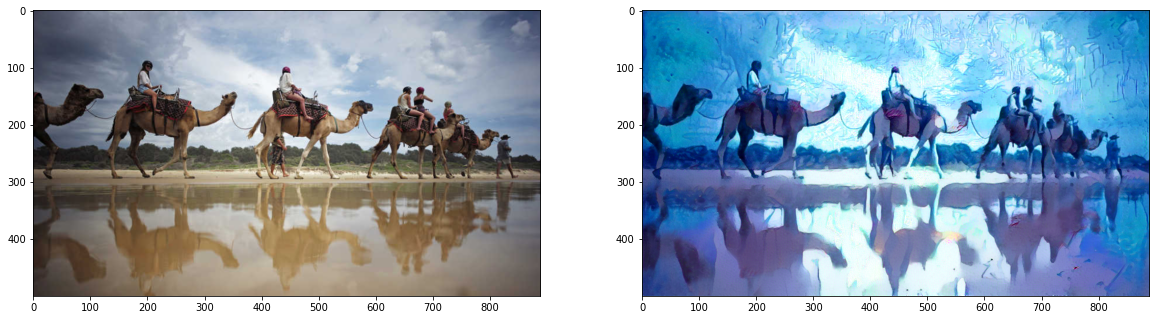

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img_convert(content))
ax2.imshow(img_convert(target))

In [16]:
plt.imsave('images/generated_images.jpg', img_convert(target))